<a href="https://colab.research.google.com/github/iaintheardofu/Clustering-Datasets/blob/master/class-1/class-1-LatentSpacePyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Michael Pendleton
Notebook: class-1-LatentSpacePyTorch.ipynb
Link: https://github.com/iaintheardofu/Clustering-Datasets/tree/master/class-1

The provided code defines and utilizes an Autoencoder neural network for the MNIST dataset. Here's a detailed explanation:

- **Autoencoder Class**: This class creates a neural network with encoder and decoder components. The encoder compresses the input image into a lower-dimensional latent space, and the decoder reconstructs the image from this latent space. The network is structured to flatten and process 28x28 grayscale MNIST images.

- **Data Loading**: Utilizes PyTorch's DataLoader to efficiently load the MNIST dataset, applying transformations to normalize the images.

- **Training Loop**: Iterates over the training dataset, feeding batches of images through the model, calculating the reconstruction loss, and updating the model's weights to minimize this loss, effectively learning to compress and reconstruct the input images.

- **Visualization**: After training, the script visualizes a batch of original images and their reconstructions from the autoencoder. It also prints the latent space representations, showcasing what the model has learned to encode.

- **Utility Functions**: Includes `imshow` for displaying tensors as images. It unnormalizes the data and uses Matplotlib to plot them.

This script encapsulates the end-to-end process of training an autoencoder on the MNIST dataset, visualizing the results, and examining the learned latent space.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

 The `Autoencoder` class inherits from `nn.Module`, a base class for all neural network modules in PyTorch. Here's a breakdown of the code and its functionality:

### Initialization Method (`__init__`)
- **Parameters**: The `__init__` method accepts a single parameter `encoding_dim`, which specifies the size of the latent space where the input data is compressed.
- **Encoder**: The encoder part of the autoencoder is designed to compress the input data (in this case, an image) into a lower-dimensional representation called the latent space. It consists of a sequence of layers:
  - `nn.Linear(28 * 28, 128)`: This layer flattens the input image (assumed to be 28x28 pixels, typical for MNIST dataset images) into a one-dimensional array and performs a linear transformation to reduce its dimension to 128.
  - `nn.ReLU(True)`: A Rectified Linear Unit (ReLU) activation function is applied to introduce non-linearity, helping the model learn complex patterns.
  - Another `nn.Linear(128, encoding_dim)`: Further reduces the dimension from 128 to the specified `encoding_dim`.
  - Another `nn.ReLU(True)`: Another ReLU activation for non-linearity.
- **Decoder**: The decoder part reconstructs the original input data from the compressed representation. It mirrors the encoder structure but in reverse, aiming to expand the compressed data back to its original shape:
  - `nn.Linear(encoding_dim, 128)`: Expands the compressed data from `encoding_dim` back to 128.
  - `nn.ReLU(True)`: Applies ReLU activation.
  - `nn.Linear(128, 28 * 28)`: Transforms the data from 128 back to the flattened image size of 784 (28x28).
  - `nn.Sigmoid()`: Applies a sigmoid activation function to ensure the output values are between 0 and 1, suitable for image data where pixel values typically fall within this range.

### Forward Method (`forward`)
- **Parameter**: The `forward` method defines how the input `x` flows through the network.
- **Process**:
  - `x.view(-1, 28*28)`: First, the input `x` is reshaped into a one-dimensional array (flattened) if not already done.
  - `self.encoder(x)`: The flattened `x` is then passed through the encoder.
  - `self.decoder(x)`: The output from the encoder, which is the compressed representation, is fed into the decoder.
- **Output**: The final output is reshaped back to the original image dimensions (`-1, 1, 28, 28`), where `-1` is a placeholder that automatically adjusts based on the batch size.


In [2]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder: compresses the image into a lower-dimensional latent space
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),  # Flatten the image and then linearly transform it
            nn.ReLU(True),  # Non-linear activation function
            nn.Linear(128, encoding_dim),  # Linear transformation to the encoding dimension
            nn.ReLU(True)  # Non-linear activation function
        )
        # Decoder: reconstructs the image from the latent space
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),  # Linearly transforms the encoding
            nn.ReLU(True),  # Non-linear activation function
            nn.Linear(128, 28 * 28),  # Transforms back to original image shape
            nn.Sigmoid()  # Sigmoid activation to output values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x.view(-1, 28*28))  # Encode the input image
        x = self.decoder(x)  # Decode the encoded image
        return x.view(-1, 1, 28, 28)  # Reshape to the original image dimensions

In [3]:

def imshow(img):
    img = img.cpu() / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()  # Convert the tensor to a numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Reshape and display the image
    plt.show()

In [4]:
# Transform: converts images to PyTorch tensors and normalizes them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [5]:
import os
import urllib.request
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

mnist_dir = "./data/MNIST/raw/"
os.makedirs(mnist_dir, exist_ok=True)

base_url = "https://github.com/nispoe/GWU-SEAS-8525/raw/main/class-1/"
files = [
    "train-images-idx3-ubyte.gz",
    "train-labels-idx1-ubyte.gz",
    "t10k-images-idx3-ubyte.gz",
    "t10k-labels-idx1-ubyte.gz"
]

for file in files:
    file_path = os.path.join(mnist_dir, file)
    if not os.path.exists(file_path):
        print(f"Downloading {file}...")
        urllib.request.urlretrieve(base_url + file, file_path)

transform = transforms.Compose([transforms.ToTensor()])

In [6]:
import gzip
import shutil

gz_files = [f for f in os.listdir(mnist_dir) if f.endswith(".gz")]

for file in gz_files:
    gz_path = os.path.join(mnist_dir, file)
    output_path = gz_path.replace(".gz", "")  # Remove .gz extension

    # Extract the file
    with gzip.open(gz_path, 'rb') as f_in:
        with open(output_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [7]:
# MNIST dataset loading
#train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_dataset = MNIST(root='./data', train=True, download=False, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(encoding_dim=64).to(device)
criterion = nn.MSELoss()  # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Optimizer

In [9]:
from torch.amp import GradScaler, autocast  # Updated import

num_epochs = 20
# Correct way to initialize GradScaler
scaler = GradScaler(device="cuda")  # New syntax

for epoch in range(num_epochs):
  for data in train_loader:
        img, _ = data
        img = img.to(device)

        with autocast(device_type="cuda"):  # Updated syntax
          output = model(img)
          loss = criterion(output, img)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/20], Loss: 0.0207
Epoch [2/20], Loss: 0.0162
Epoch [3/20], Loss: 0.0135
Epoch [4/20], Loss: 0.0103
Epoch [5/20], Loss: 0.0098
Epoch [6/20], Loss: 0.0077
Epoch [7/20], Loss: 0.0071
Epoch [8/20], Loss: 0.0085
Epoch [9/20], Loss: 0.0081
Epoch [10/20], Loss: 0.0075
Epoch [11/20], Loss: 0.0058
Epoch [12/20], Loss: 0.0067
Epoch [13/20], Loss: 0.0059
Epoch [14/20], Loss: 0.0048
Epoch [15/20], Loss: 0.0054
Epoch [16/20], Loss: 0.0061
Epoch [17/20], Loss: 0.0059
Epoch [18/20], Loss: 0.0057
Epoch [19/20], Loss: 0.0072
Epoch [20/20], Loss: 0.0056


Original Images


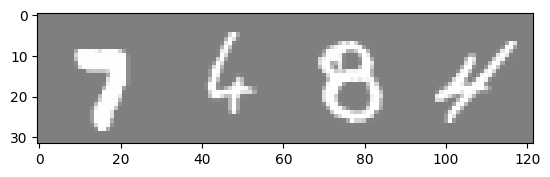

Reconstructed Images


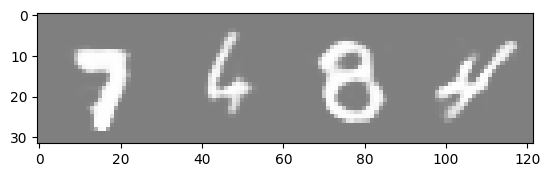

Latent space representations:
tensor([[ 0.0000,  0.0000,  8.7625,  0.0000,  5.4033,  0.0000,  8.2284, 11.9488,
          6.0957,  0.0000,  7.9303,  6.1205,  4.2303,  6.8919,  4.5741,  6.8321,
         13.4202, 11.9029,  6.5316,  0.0000, 10.9383,  9.0687,  0.0000,  7.1502,
          5.5515,  9.9374,  5.6177,  7.5329,  9.4078,  0.0000, 12.9713,  9.5262,
          1.8753, 11.0398, 10.8061,  4.7136,  6.7834, 16.1453,  5.2802, 11.0750,
          9.4370,  6.8964,  0.0000, 13.1595,  0.0000,  0.0000,  0.0000,  0.0000,
         13.2130,  0.0000,  8.1831,  0.0000,  7.7944,  0.0000,  0.0000,  0.0000,
          6.6612, 14.3476,  0.0000,  0.0000,  5.9781, 12.1672,  0.0000,  4.5154],
        [ 0.0000,  0.0000,  5.7751,  0.0000,  8.5459,  0.0000,  7.7984,  5.7947,
          5.9626,  0.0000,  5.6308,  6.3228,  3.6942,  5.2382,  5.3018,  1.8575,
          3.0440,  4.4724,  2.9623,  0.0000,  6.3259, 10.7115,  0.0000,  3.7678,
          3.5271,  3.4847,  4.5884,  8.8562,  3.1084,  0.0000,  5.7922,  6.005

In [10]:
# Load a batch of test images
dataiter = iter(train_loader)
images, _ = next(dataiter)
images = images.to(device)

# Show original images
print("Original Images")
imshow(vutils.make_grid(images[:4].cpu(), normalize=True))

# Encode + Decode (inference)
with torch.no_grad():
	encoded_imgs = model.encoder(images.view(-1, 28 * 28)[:4])
	decoded_imgs = model.decoder(encoded_imgs).view(-1, 1, 28, 28)

# Show reconstructed images
print("Reconstructed Images")
imshow(vutils.make_grid(decoded_imgs[:4].cpu(), normalize=True))

# Print latent vectors
print("Latent space representations:")
print(encoded_imgs)

Original Images


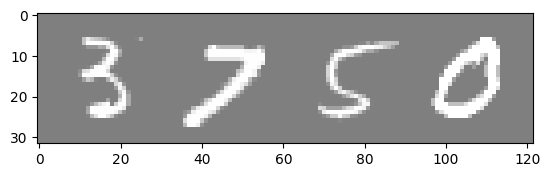

Original Representation
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
       

In [11]:
# Visualization of the original and reconstructed images
dataiter = iter(train_loader)
images, _ = next(dataiter)
images = images.to(device)

# Display original images
print("Original Images")
imshow(vutils.make_grid(images[:4], normalize=True))

# Encoded and decoded images
with torch.no_grad():
    encoded_imgs = model.encoder(images.view(-1, 28*28)[:4])
    decoded_imgs = model.decoder(encoded_imgs).view(-1, 1, 28, 28)


# Display reconstructed images
print("Original Representation")
print(img)

# Print latent space
print("Latent space representations:")
print(encoded_imgs)